In [61]:
from datetime import datetime
import os

from google.cloud import bigquery, storage
import pandas as pd

In [62]:
bigquery_client = bigquery.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")
storage_client = storage.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")

In [63]:
TODAY = datetime(year=2025, month=8, day=2)

# Generate bigquery tables for measurements, failures, and metadata from raw data in GCS

In [53]:
def load_folder_into_bigquery(folder_url: str, table_id: str, bigquery_client: bigquery.Client, storage_client: storage.Client):
    """
    Loads all files from a given folder in Google Cloud Storage into a BigQuery table.
    Auto-detects:
        - File format (CSV, NDJSON, Parquet) from a single file in the folder.
        - Schema from the file contents.
    Overwrites the table if it already exists.
    After ingestion:
        - If a column named 'timestamp' exists and is inferred as DATE,
          automatically converts it into TIMESTAMP.
    Assumes all files in the folder are of the same format.
    """

    # Normalize folder path (ensure trailing slash)
    if not folder_url.endswith("/"):
        folder_url += "/"

    # Extract bucket name & prefix from folder URL
    if not folder_url.startswith("gs://"):
        raise ValueError("folder_url must start with 'gs://'")
    bucket_name = folder_url.split("/")[2]
    prefix = "/".join(folder_url.split("/")[3:])

    # Use GCS client to find one file in the folder
    blobs = list(storage_client.list_blobs(bucket_name, prefix=prefix, max_results=1))

    if not blobs:
        raise FileNotFoundError(f"No files found in {folder_url}")

    # Get the first file's extension to determine source format
    first_file = blobs[0].name
    extension = os.path.splitext(first_file)[1].lower()

    # Map file extension to BigQuery source format
    if extension == ".csv":
        source_format = bigquery.SourceFormat.CSV
    elif extension in (".json", ".ndjson"):
        source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
    elif extension == ".parquet":
        source_format = bigquery.SourceFormat.PARQUET
    else:
        raise ValueError(f"Unsupported file format '{extension}' in {first_file}")

    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        source_format=source_format
    )

    # Start the load job for all files in the folder
    load_job = bigquery_client.load_table_from_uri(
        f"{folder_url}*",
        table_id,
        job_config=job_config,
    )

    # Wait for completion and handle errors
    try:
        load_job.result()
    except Exception as e:
        print(f"❌ BigQuery load failed: {e}")
        if load_job.errors:
            print("BigQuery job errors:", load_job.errors)
        raise

    # Check if 'timestamp' column exists and its type
    table = bigquery_client.get_table(table_id)
    timestamp_field = next((f for f in table.schema if f.name.lower() == "timestamp"), None)

    if timestamp_field:
        if timestamp_field.field_type.upper() == "DATE":
            print(f"ℹ️ Column 'timestamp' detected as DATE. Converting to TIMESTAMP...")

            query = f"""
            CREATE OR REPLACE TABLE `{table_id}` AS
            SELECT
                CAST(timestamp AS TIMESTAMP) AS timestamp,
                *
            EXCEPT(timestamp)
            FROM `{table_id}`
            """

            bigquery_client.query(query).result()
            print(f"✅ Converted 'timestamp' column from DATE to TIMESTAMP in {table_id}.")
        else:
            print(f"✅ Column 'timestamp' already has type {timestamp_field.field_type}. No conversion needed.")
    else:
        print(f"ℹ️ No 'timestamp' column found in {table_id}.")

    # Fetch the table and report
    destination_table = bigquery_client.get_table(table_id)
    print(f"✅ Loaded {destination_table.num_rows} rows into {table_id} ({source_format}).")

In [ ]:
for data_type in ["measurements", "failures", "metadata"]:
    load_folder_into_bigquery(
        folder_url=f"gs://neuraltwin/data/wagon_data/{data_type}/",
        table_id=f"neuraltwin.wagon_data.{data_type}",
        bigquery_client=bigquery_client,
        storage_client=storage_client
    )

✅ Column 'timestamp' already has type TIMESTAMP. No conversion needed.
✅ Loaded 109973 rows into neuraltwin.wagon_data.measurements (PARQUET).


# load data into pandas dataframes

In [4]:
measurements = pd.read_gbq(
    "SELECT * FROM `neuraltwin.wagon_data.measurements`",
    project_id="neuraltwin",
    dialect="standard"
)
failures = pd.read_gbq(
    "SELECT id, timestamp FROM `neuraltwin.wagon_data.failures`",
    project_id="neuraltwin",
    dialect="standard"
)

# Train classification model

In [5]:
training_data = measurements
training_data["failure"] = 0.0
# in training data, set the failure flag to 1.0 for rows where id and timestamp match failures table
for _, row in failures.iterrows():
    training_data.loc[
        (training_data["id"] == row["id"]) & (training_data["timestamp"] == row["timestamp"]),
        "failure"
    ] = 1.0
training_data.drop(columns=["id", "timestamp"], inplace=True)

,Description,Value
0,Session id,3232
1,Target,failure
2,Target type,Binary
3,Original data shape,"(109973, 6)"
4,Transformed data shape,"(109973, 6)"
5,Transformed train set shape,"(76981, 6)"
6,Transformed test set shape,"(32992, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9963,0.9981,1.0000,0.4965,0.6633,0.6616,0.7032,0.0550
qda,Quadratic Discriminant Analysis,0.0036,0.0000,1.0000,0.0036,0.0072,0.0000,0.0000,0.0870
lda,Linear Discriminant Analysis,0.9965,0.9983,0.9783,0.5082,0.6683,0.6667,0.7035,0.0800
gbc,Gradient Boosting Classifier,0.9963,0.8980,0.7815,0.4970,0.6007,0.5990,0.6179,8.1250
lightgbm,Light Gradient Boosting Machine,0.9607,0.8558,0.5093,0.3635,0.3811,0.3780,0.3909,0.4570
knn,K Neighbors Classifier,0.9962,0.9892,0.5017,0.4817,0.4878,0.4860,0.4879,0.3740
ada,Ada Boost Classifier,0.9965,0.9917,0.4980,0.5079,0.4999,0.4981,0.4997,2.3160
dt,Decision Tree Classifier,0.9962,0.7428,0.4874,0.4807,0.4830,0.4811,0.4817,0.1500
rf,Random Forest Classifier,0.9962,0.9980,0.4766,0.4727,0.4696,0.4677,0.4702,1.3770
lr,Logistic Regression,0.9963,0.9983,0.4730,0.4903,0.4787,0.4769,0.4783,2.7370


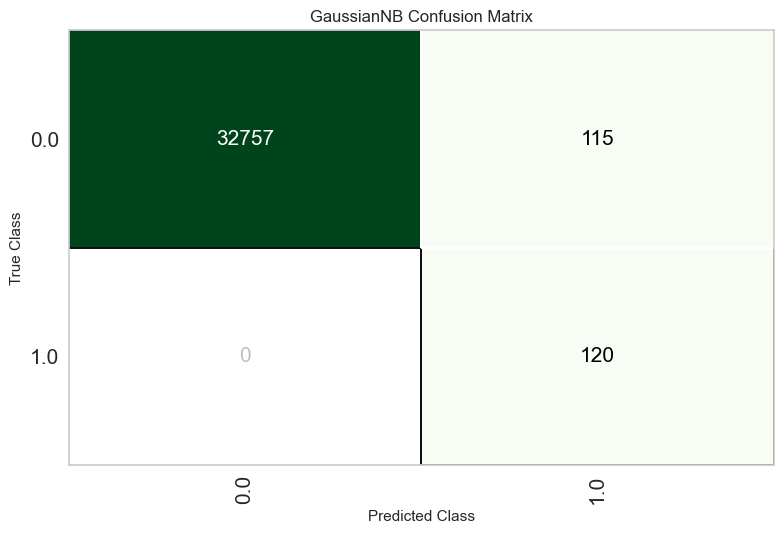

In [6]:
from pycaret.classification import setup, compare_models, plot_model

clf = setup(data=training_data, target="failure")

best = compare_models(sort="Recall")  # Sort models by recall
plot_model(best, plot="confusion_matrix")

In [11]:
best_model = best

In [12]:
# save the model
import joblib
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

# Forecasting future measurements using BigQuery ML

In [40]:
measurements_table="neuraltwin.wagon_data.measurements",
cols_names=measurements.columns.tolist()[:-1]
cols_names

['speed', 'brake', 'temp', 'vibration', 'battery']

In [51]:
def forcast_single_column(measurements_table: str, col_name: str) -> pd.DataFrame:
    """
    Forcasts a single column using BigQuery ML's AI.FORECAST function.
    Returns a DataFrame with columns: id, timestamp, <col_name>
    """
    sql = f"""
        SELECT *
        FROM AI.FORECAST(
            TABLE `neuraltwin.wagon_data.measurements`,
            data_col => '{col_name}',
            timestamp_col => 'timestamp',
            model => 'TimesFM 2.0',
            id_cols => ['id'],
            horizon => 30,
            confidence_level => .75
        )
    """
    forecast = pd.read_gbq(sql, project_id="neuraltwin", dialect="standard")
    forecast[col_name] = forecast["forecast_value"]
    forecast["timestamp"] = forecast["forecast_timestamp"]
    forecast = forecast[["id", "timestamp", col_name]]
    return forecast

all_forecasts = []
for col_name in cols_names:
    all_forecasts.append(forcast_single_column(measurements_table, col_name))

In [52]:
# merge all forecasts on id and forecast_timestamp
forecast = all_forecasts[0]
for f in all_forecasts[1:]:
    forecast = forecast.merge(f, on=["id", "timestamp"])

In [54]:
forecast.to_gbq(
    destination_table="neuraltwin.wagon_data.forecast",
    project_id="neuraltwin",
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [55]:
# read forecast table
# forecasted_data = pd.read_gbq(
#     "SELECT * FROM `neuraltwin.wagon_data.forecast`",
#     project_id="neuraltwin",
#     dialect="standard"
# )

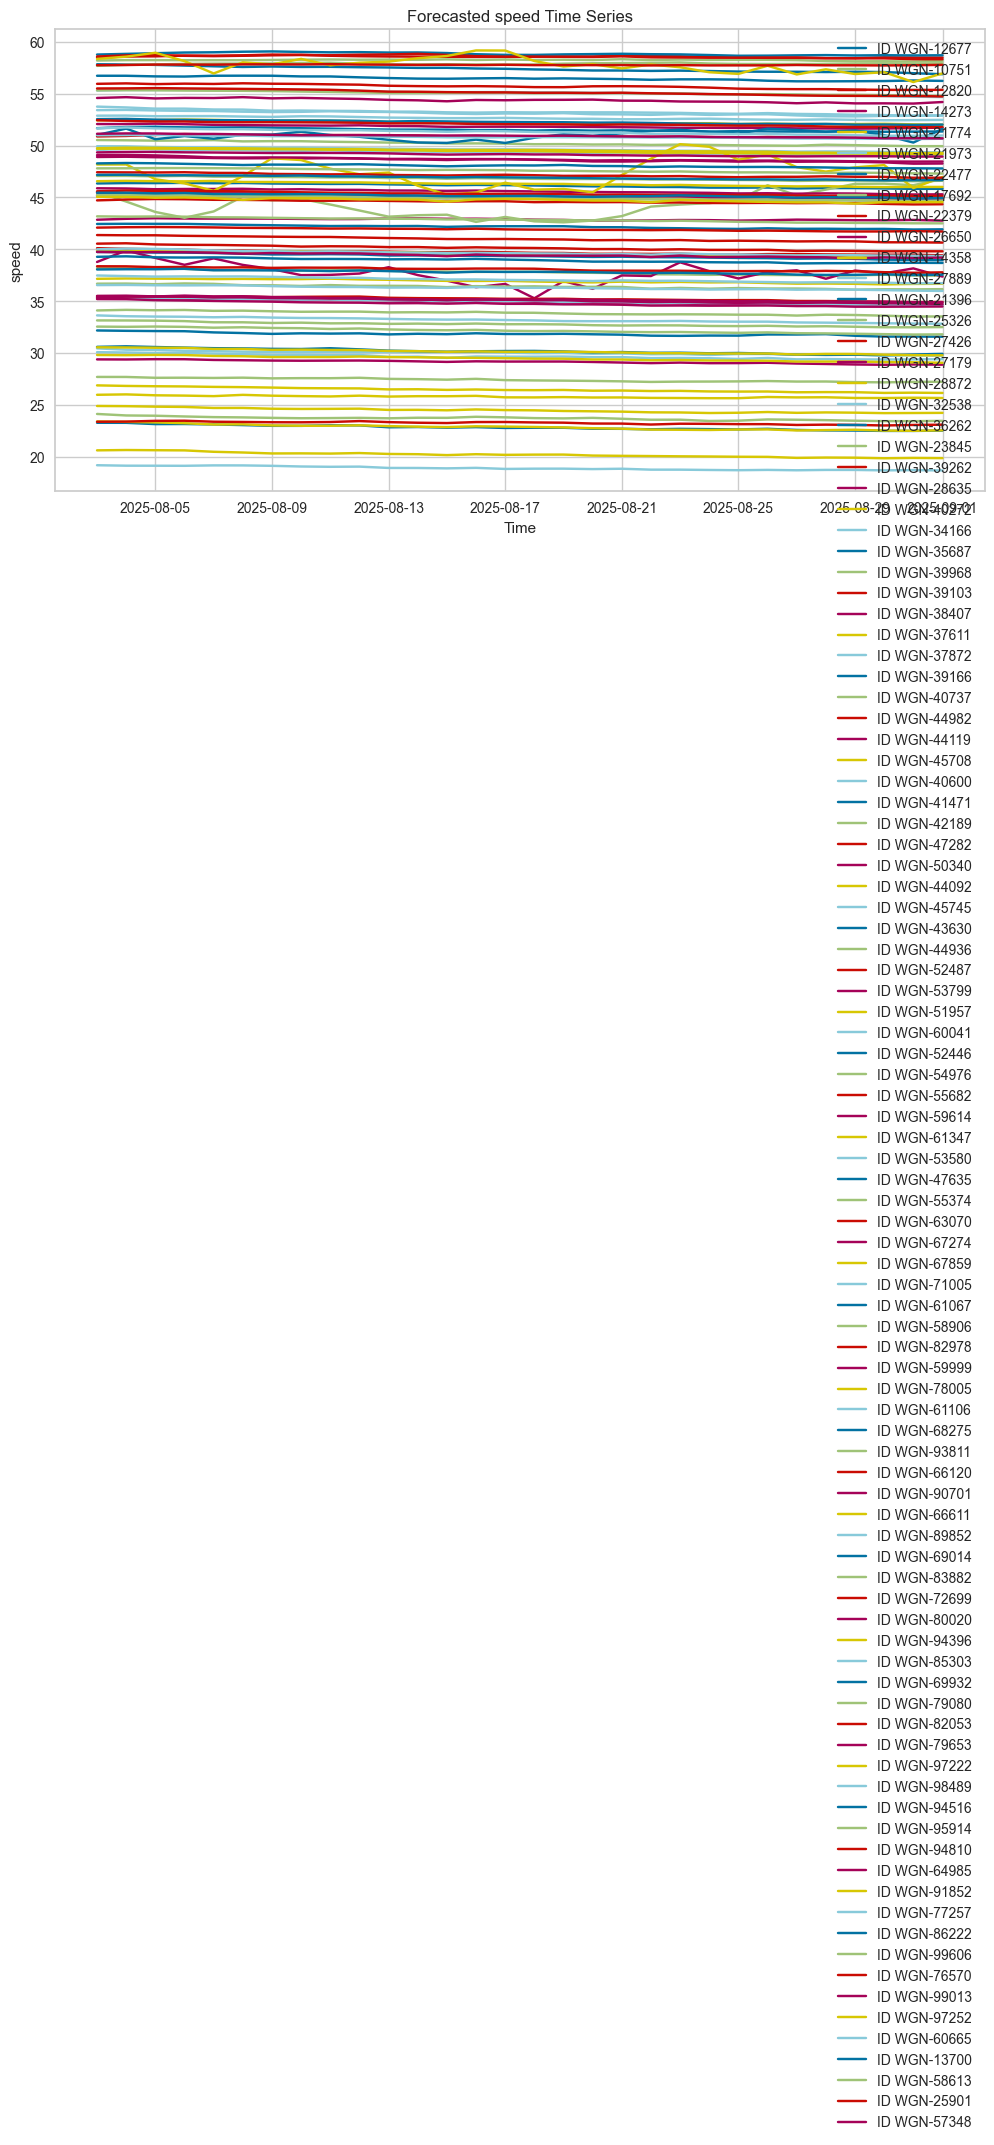

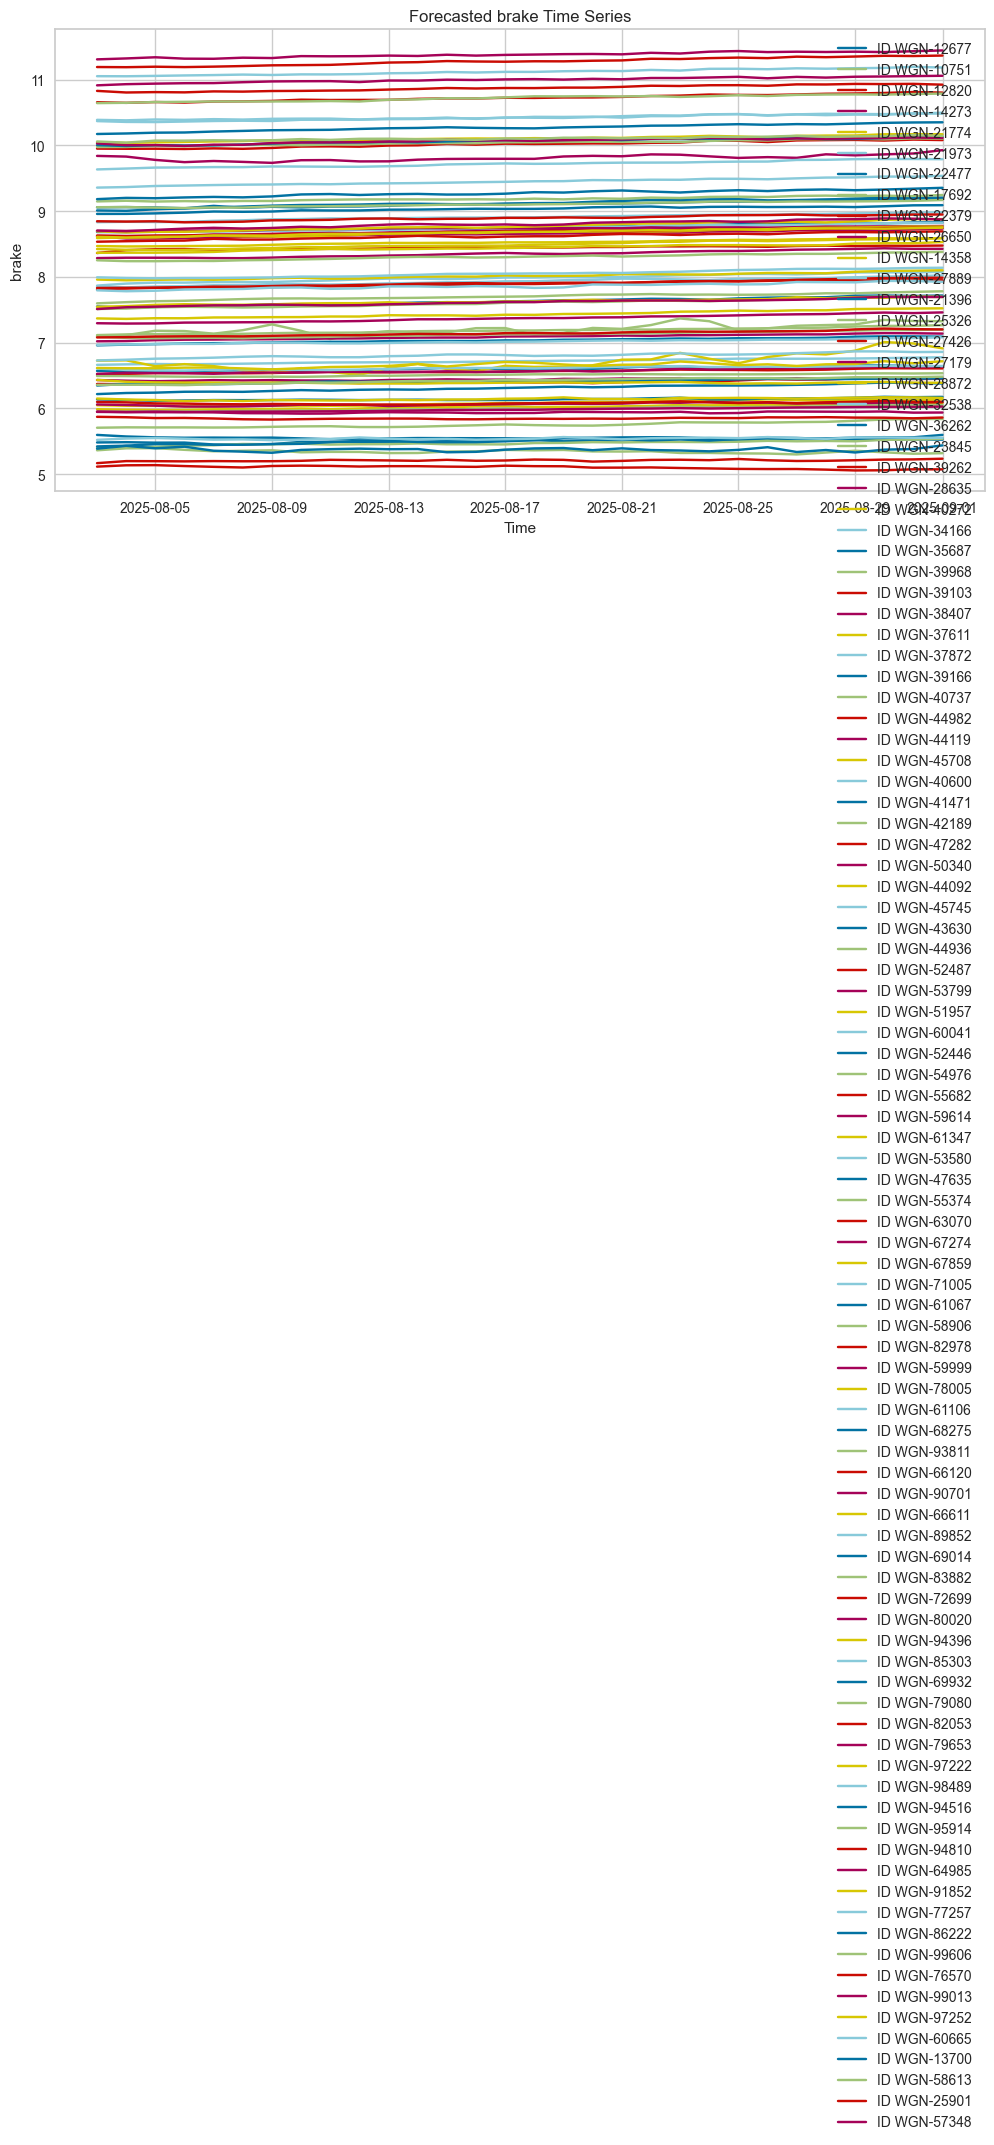

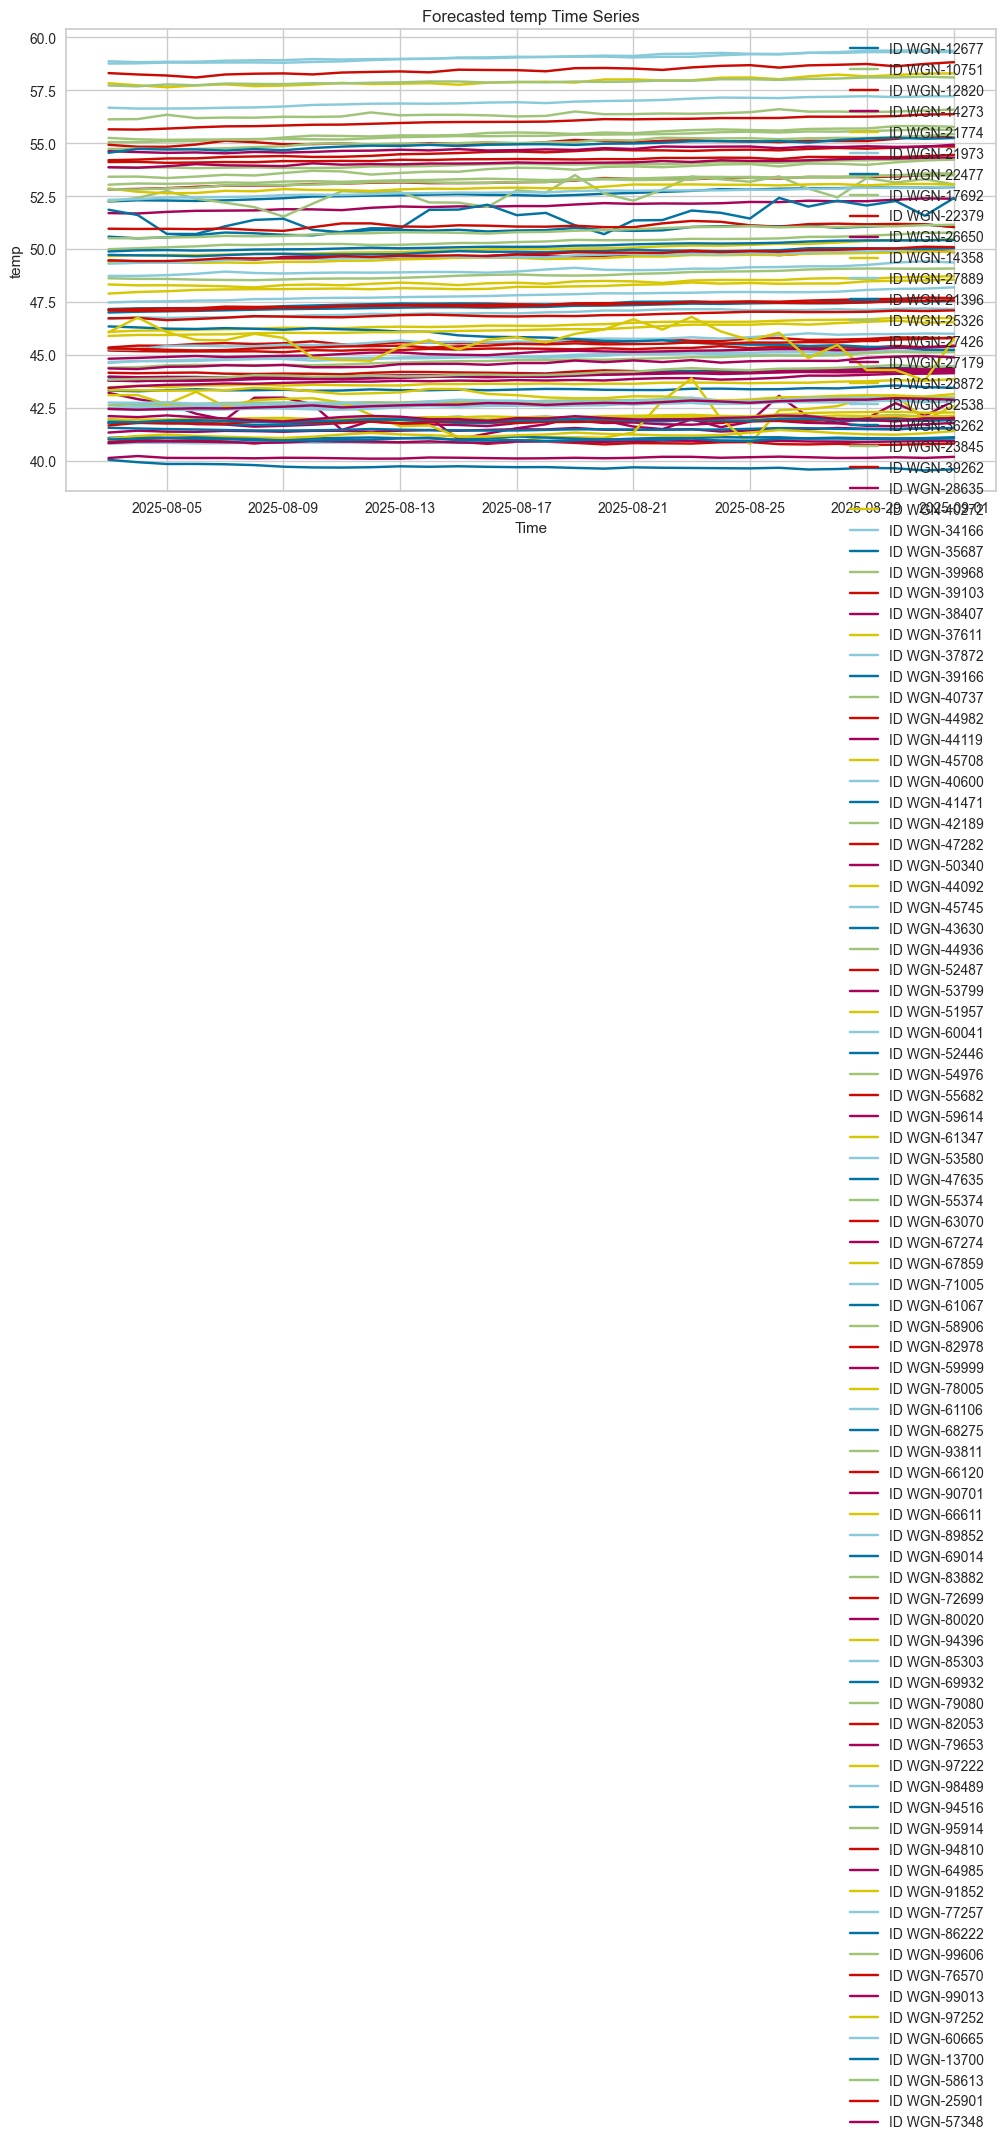

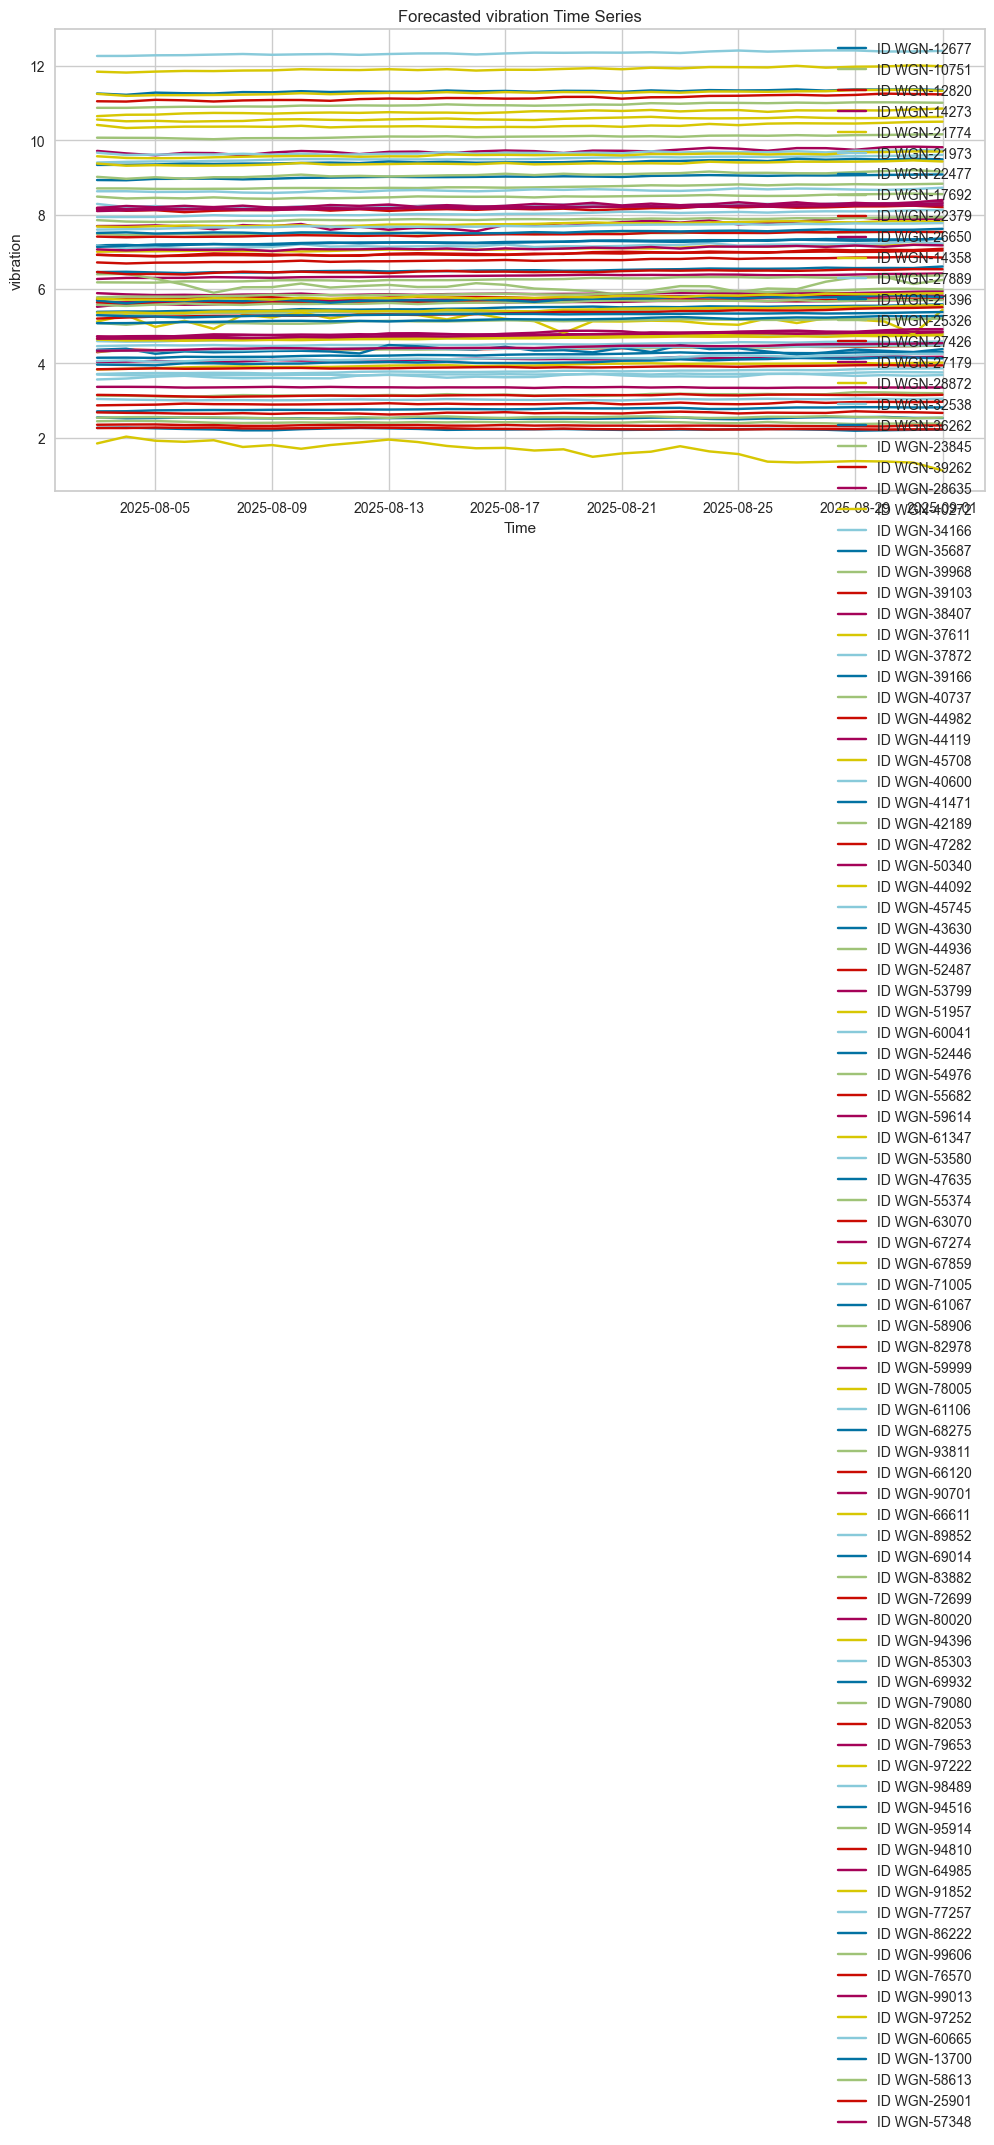

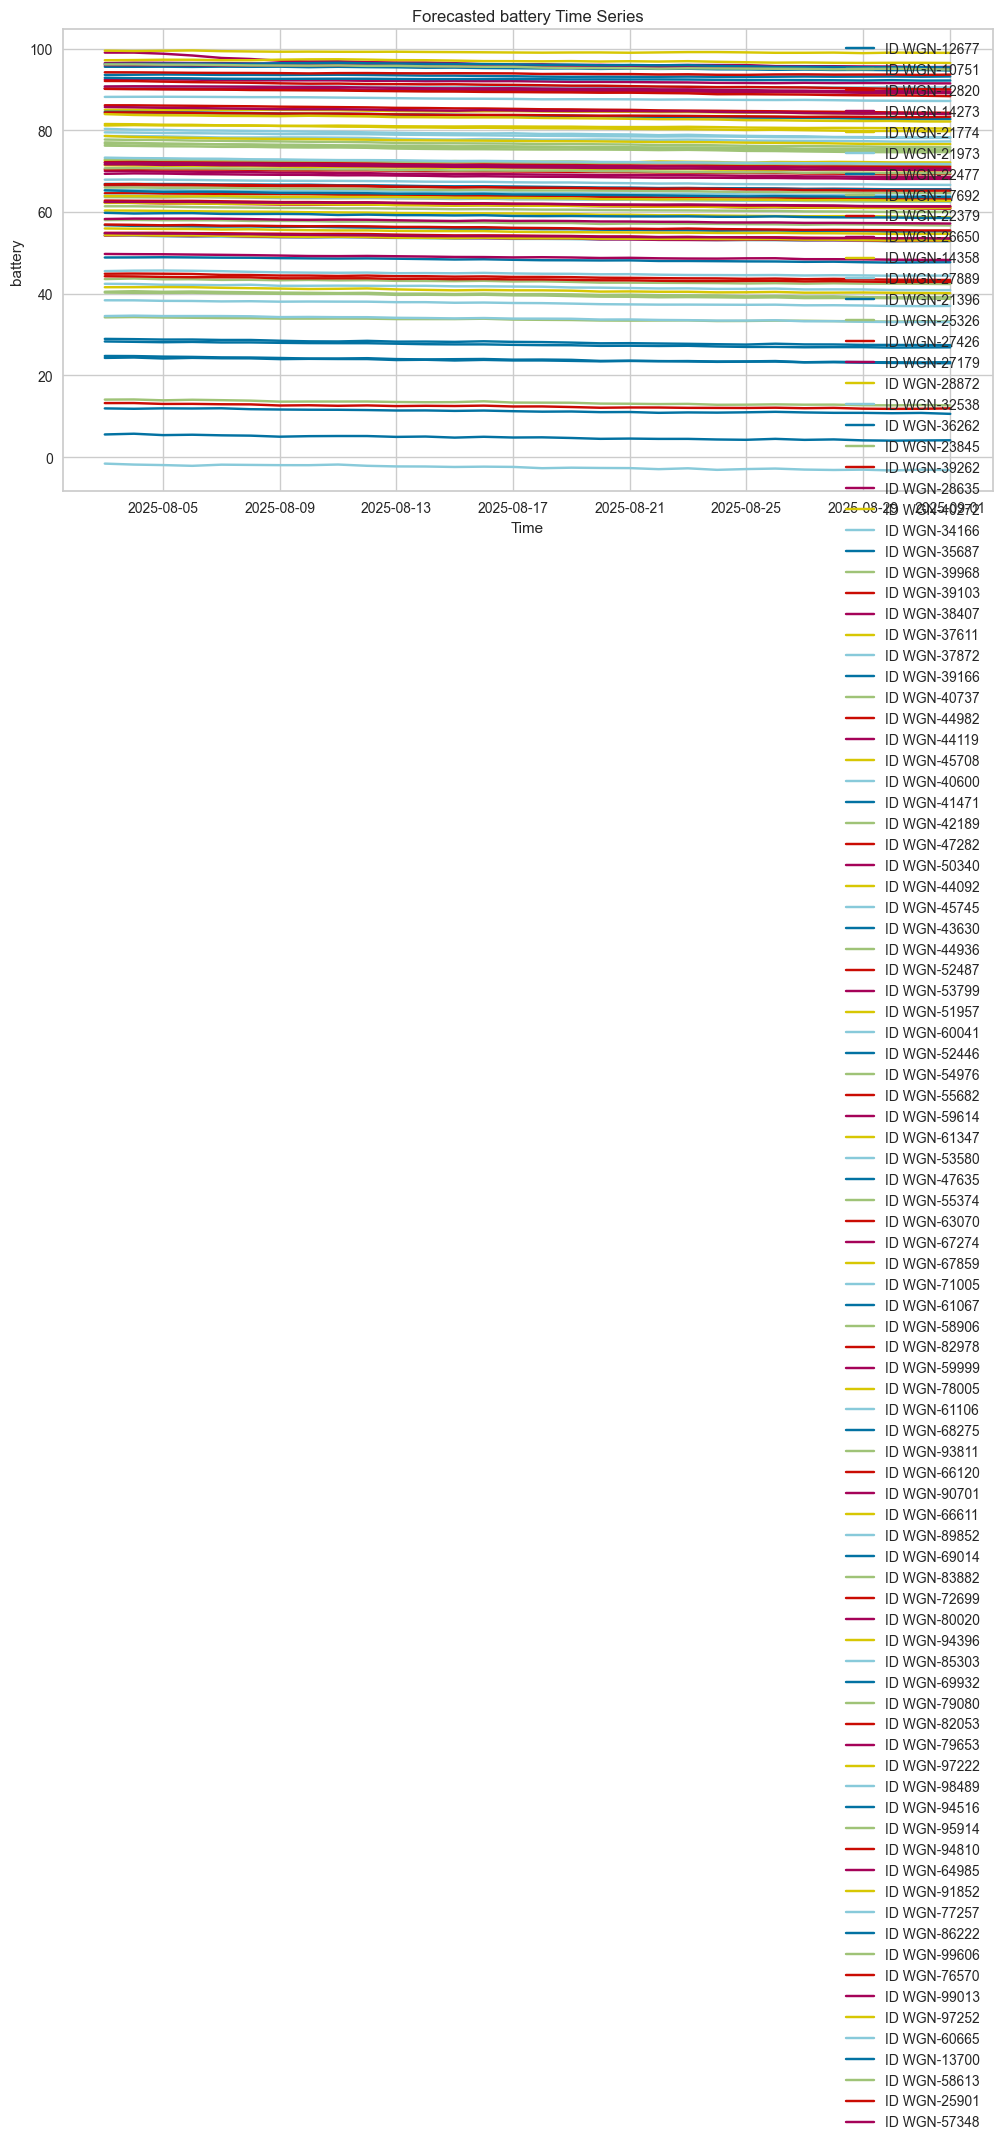

In [60]:
# visualize forecast dataframe time series for each id
import matplotlib.pyplot as plt

for col_name in cols_names:
    plt.figure(figsize=(12, 6))
    for id in forecast["id"].unique():
        plt.plot(forecast[forecast["id"] == id]["timestamp"], forecast[forecast["id"] == id][col_name], label=f"ID {id}")
    plt.title(f"Forecasted {col_name} Time Series")
    plt.xlabel("Time")
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

In [56]:
forecasted_failures = best_model.predict(forecast.drop(columns=["id", "timestamp"]))

In [58]:
n_forecased_failures = forecasted_failures.sum()
n_forecased_failures

0.0

# Generate pdf report

In [66]:
metadata = pd.read_gbq(
    "SELECT * FROM `neuraltwin.wagon_data.metadata`",
    project_id="neuraltwin",
    dialect="standard"
)

In [ ]:
recent_failures = pd.read_gbq(
    "SELECT * " \
    "FROM `neuraltwin.wagon_data.failures` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)

In [82]:
recent_measurements = pd.read_gbq(
    "SELECT * " \
    "FROM `neuraltwin.wagon_data.measurements` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)

In [94]:
pdf_report_receiver = "Operator"

In [95]:
enriched_recent_failures = recent_failures.merge(metadata, on="id", how="left")
enriched_recent_failures

def generate_failure_json_summary_for_report(df: pd.DataFrame) -> dict:
    summary = {
        "n_recent_failures": len(df),
        "n_percentage_failed": (len(df) / df["id"].nunique()) * 100 if df["id"].nunique() > 0 else 0,
        "n_failures_by_type": df["failure_type"].value_counts().to_dict() if "failure_type" in df.columns else {},
        "failure_ids": df["id"].tolist(),
        "failure_details": df.to_dict(orient="records")
    }
    return summary

failure_details_for_report = (
    enriched_recent_failures
    .groupby(pdf_report_receiver)
    .apply(generate_failure_json_summary_for_report)
)

In [96]:
enriched_recent_measurements = recent_measurements.merge(metadata, on="id", how="left")
measurement_details_for_report = (
    enriched_recent_measurements
    .groupby(pdf_report_receiver)
    .apply(lambda df: df.describe().to_dict())
)
measurement_details_for_report

Operator
Brennan-Peterson               {'speed': {'count': 372.0, 'mean': 40.76988876...
Charles and Sons               {'speed': {'count': 372.0, 'mean': 41.01191279...
Harris-Jenkins                 {'speed': {'count': 403.0, 'mean': 39.78515137...
Hendricks and Sons             {'speed': {'count': 248.0, 'mean': 45.71942146...
Martin, Rogers and Mitchell    {'speed': {'count': 279.0, 'mean': 48.59862402...
Rodriguez and Sons             {'speed': {'count': 434.0, 'mean': 45.45562403...
Thomas Group                   {'speed': {'count': 217.0, 'mean': 43.41347044...
Torres-Ortiz                   {'speed': {'count': 186.0, 'mean': 45.15661587...
Wilson-Johnson                 {'speed': {'count': 186.0, 'mean': 36.94627127...
Wolfe and Sons                 {'speed': {'count': 403.0, 'mean': 40.98080614...
dtype: object

In [100]:
details_for_report = pd.DataFrame(
    {
        "failure_details": failure_details_for_report,
        "measurement_details": measurement_details_for_report
    }
)
details_for_report.reset_index(inplace=True)
details_for_report

,Operator,failure_details,measurement_details
0,Brennan-Peterson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 40.76988876..."
1,Charles and Sons,"{'n_recent_failures': 2, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 41.01191279..."
2,Harris-Jenkins,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 39.78515137..."
3,Hendricks and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 248.0, 'mean': 45.71942146..."
4,"Martin, Rogers and Mitchell",NaN,"{'speed': {'count': 279.0, 'mean': 48.59862402..."
5,Rodriguez and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 434.0, 'mean': 45.45562403..."
6,Thomas Group,NaN,"{'speed': {'count': 217.0, 'mean': 43.41347044..."
7,Torres-Ortiz,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 45.15661587..."
8,Wilson-Johnson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 36.94627127..."
9,Wolfe and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 40.98080614..."


In [133]:
details_for_report["prompt"] = details_for_report.apply(lambda row: f"""
Create an HTML report for IIoT sensor data and failures for {row[pdf_report_receiver]} with three sections. In a first section, provide a written a summary of the most important overall details using only text. In a second section, provide a summary paragraph and a table for details on failures. In the third section, summarize measurements details first in a written paragraph and then in a table. Make sure the report looks professional when subsequently transformed into a pdf with fpdf2. Also, don't include anything unnecessary like descriptions of how you have created the report or newline symbols. Here is the json summary of the recent data:
- Failure Details: {row['failure_details']}
- Measurement Details: {row['measurement_details']}
""", axis=1)
details_for_report

,Operator,failure_details,measurement_details,prompt
0,Brennan-Peterson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 40.76988876...",\nCreate an HTML report for IIoT sensor data a...
1,Charles and Sons,"{'n_recent_failures': 2, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 41.01191279...",\nCreate an HTML report for IIoT sensor data a...
2,Harris-Jenkins,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 39.78515137...",\nCreate an HTML report for IIoT sensor data a...
3,Hendricks and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 248.0, 'mean': 45.71942146...",\nCreate an HTML report for IIoT sensor data a...
4,"Martin, Rogers and Mitchell",NaN,"{'speed': {'count': 279.0, 'mean': 48.59862402...",\nCreate an HTML report for IIoT sensor data a...
5,Rodriguez and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 434.0, 'mean': 45.45562403...",\nCreate an HTML report for IIoT sensor data a...
6,Thomas Group,NaN,"{'speed': {'count': 217.0, 'mean': 43.41347044...",\nCreate an HTML report for IIoT sensor data a...
7,Torres-Ortiz,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 45.15661587...",\nCreate an HTML report for IIoT sensor data a...
8,Wilson-Johnson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 36.94627127...",\nCreate an HTML report for IIoT sensor data a...
9,Wolfe and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 40.98080614...",\nCreate an HTML report for IIoT sensor data a...


In [134]:
report_details_table_name = f"neuraltwin.wagon_data.reports_{TODAY.strftime('%Y_%m_%d')}"
details_for_report[[pdf_report_receiver, "prompt"]].to_gbq(
    destination_table=report_details_table_name,
    project_id="neuraltwin",
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [135]:
details_for_report

,Operator,failure_details,measurement_details,prompt
0,Brennan-Peterson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 40.76988876...",\nCreate an HTML report for IIoT sensor data a...
1,Charles and Sons,"{'n_recent_failures': 2, 'n_percentage_failed'...","{'speed': {'count': 372.0, 'mean': 41.01191279...",\nCreate an HTML report for IIoT sensor data a...
2,Harris-Jenkins,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 39.78515137...",\nCreate an HTML report for IIoT sensor data a...
3,Hendricks and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 248.0, 'mean': 45.71942146...",\nCreate an HTML report for IIoT sensor data a...
4,"Martin, Rogers and Mitchell",NaN,"{'speed': {'count': 279.0, 'mean': 48.59862402...",\nCreate an HTML report for IIoT sensor data a...
5,Rodriguez and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 434.0, 'mean': 45.45562403...",\nCreate an HTML report for IIoT sensor data a...
6,Thomas Group,NaN,"{'speed': {'count': 217.0, 'mean': 43.41347044...",\nCreate an HTML report for IIoT sensor data a...
7,Torres-Ortiz,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 45.15661587...",\nCreate an HTML report for IIoT sensor data a...
8,Wilson-Johnson,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 186.0, 'mean': 36.94627127...",\nCreate an HTML report for IIoT sensor data a...
9,Wolfe and Sons,"{'n_recent_failures': 1, 'n_percentage_failed'...","{'speed': {'count': 403.0, 'mean': 40.98080614...",\nCreate an HTML report for IIoT sensor data a...


In [136]:
query = f"""SELECT
  {pdf_report_receiver},
  AI.GENERATE(
    ('', prompt),
    connection_id => 'projects/neuraltwin/locations/eu/connections/vertex-ai-connecton-neuraltwin',
    endpoint => 'gemini-2.0-flash-lite'
  ).result AS report
FROM
  `{report_details_table_name}`;
"""
reports = bigquery_client.query(query).to_dataframe()

In [137]:
# print html report for the first receiver
reports.iloc[0]["report"]

'```html\n<!DOCTYPE html>\n<html>\n<head>\n<title>IIoT Sensor Data Report - Martin, Rogers, Mitchell</title>\n<style>\nbody { font-family: sans-serif; }\nh1, h2 { color: #333; }\ntable { width: 100%; border-collapse: collapse; margin-bottom: 20px; }\nth, td { border: 1px solid #ddd; padding: 8px; text-align: left; }\nth { background-color: #f2f2f2; }\n</style>\n</head>\n<body>\n\n<h1>IIoT Sensor Data Report - Martin, Rogers, Mitchell</h1>\n\n<section>\n    <h2>Summary</h2>\n    <p>This report summarizes the recent sensor data collected from the IIoT devices.  The data covers speed, brake pressure, temperature, vibration, battery level, and dimensional measurements (Height, Length, Width) and capacity. No failures were recorded during the reporting period.</p>\n</section>\n\n<section>\n    <h2>Failure Details</h2>\n    <p>No failures were recorded during the reporting period. </p>\n</section>\n\n<section>\n    <h2>Measurement Details</h2>\n    <p>The sensor data includes a range of meas

In [ ]:
report = reports.iloc[0]["report"]
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.write_html(report)
pdf.output("report.pdf")

In [138]:
# for each report, save it as a pdf in a gcs directory of today's date using fpdf2
from fpdf import FPDF
import tempfile
for _, row in reports.iterrows():
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)

    # Add HTML content
    pdf.write_html(row["report"])

    # Save to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
        pdf.output(tmp_file.name)
        tmp_file_path = tmp_file.name

    # # Upload to GCS
    # bucket_name = "neuraltwin"
    # destination_blob_name = f"reports/{TODAY.strftime('%Y_%m_%d')}/{row[pdf_report_receiver].replace(' ', '_')}_report.pdf"
    # bucket = storage_client.bucket(bucket_name)
    # blob = bucket.blob(destination_blob_name)
    # blob.upload_from_filename(tmp_file_path)

    # print(f"Uploaded report for {row[pdf_report_receiver]} to gs://{bucket_name}/{destination_blob_name}")

    # # Clean up temporary file
    # os.remove(tmp_file_path)

In [30]:
metadata_object_columns = metadata.columns[metadata.dtypes == "object"].drop("id")

In [36]:
# find the object column in metadata with the least amount of unique values
{
    col: len(metadata[col].value_counts())
    for col in metadata_object_columns
}

{'Operator': 100, 'Owner': 100, 'Type': 6}

In [33]:
metadata[metadata_object_columns].value_counts()

Operator          Owner                      Type            
Berg-Houston      Nicholson PLC              Hopper              1
Oneal-Graham      Murphy-Patrick             Hopper              1
Reed-Hart         Torres-Scott               Refrigerator Car    1
Ray-Bradford      Hill, Adams and Savage     Gondola             1
Pope-Green        Shaw LLC                   Gondola             1
                                                                ..
Harris-Jenkins    Hanson-Williams            Boxcar              1
Harris LLC        Curry, Wyatt and Mitchell  Boxcar              1
Hardin-Anderson   Rowe-Holden                Gondola             1
Guzman and Sons   Lopez, Lee and Thompson    Hopper              1
Zuniga-Hernandez  Petersen Group             Tank Car            1
Name: count, Length: 100, dtype: int64

In [18]:
metadata = pd.read_gbq(
    "SELECT * FROM `neuraltwin.wagon_data.metadata`",
    project_id="neuraltwin",
    dialect="standard"
)
# merge recent_failures with metadata on id
recent_failures_enriched = recent_failures.merge(metadata, on="id", how="left")

In [19]:
recent_failures_enriched

,timestamp,repair_time,downtime,cause,id,Sensor_Installation_Date,Manufacture_Date,Operator,Height_m,Length_m,Owner,Width_m,Capacity_tons,Type
0,2025-07-25 00:00:00+00:00,2025-07-26 00:00:00+00:00,1 days 00:00:00,axle failure,WGN-97252,2021-08-29,2006-06-22,"Jones, Reese and Collier",2.78,23.90,"Davis, Short and Neal",3.40,38,Refrigerator Car
1,2025-07-24 00:00:00+00:00,2025-07-24 17:00:00+00:00,0 days 17:00:00,battery failure,WGN-37611,2021-05-12,1998-10-02,Wilson-Johnson,4.06,18.39,"Wilson, Zavala and Taylor",3.10,120,Gondola
2,2025-07-28 00:00:00+00:00,2025-07-28 21:00:00+00:00,0 days 21:00:00,battery failure,WGN-26650,2023-09-24,2019-10-09,Payne-Davis,2.59,17.84,"Johnson, Stevens and Young",2.96,80,Flatcar
3,2025-07-04 00:00:00+00:00,2025-07-04 05:00:00+00:00,0 days 05:00:00,brakes failure,WGN-17692,2020-12-07,2004-06-28,"Garcia, Huff and Adams",3.84,11.62,Sandoval and Sons,3.29,47,Flatcar
4,2025-07-12 00:00:00+00:00,2025-07-12 10:00:00+00:00,0 days 10:00:00,brakes failure,WGN-44982,2022-12-30,2017-04-03,Harris-Jenkins,4.47,20.19,Hanson-Williams,3.36,61,Boxcar
5,2025-07-03 00:00:00+00:00,2025-07-03 12:00:00+00:00,0 days 12:00:00,brakes failure,WGN-22379,2022-12-25,2014-11-02,Fletcher Group,2.97,14.33,Leach-Thompson,3.29,32,Hopper
6,2025-07-20 00:00:00+00:00,2025-07-20 12:00:00+00:00,0 days 12:00:00,cooling failure,WGN-39103,2024-05-18,2003-06-09,Oneal-Graham,4.39,18.24,Murphy-Patrick,3.28,29,Hopper
7,2025-07-10 00:00:00+00:00,2025-07-10 17:00:00+00:00,0 days 17:00:00,cooling failure,WGN-53799,2024-03-01,2000-10-18,Byrd-Williams,3.16,8.16,"Allen, Page and Larson",2.70,116,Tank Car
8,2025-07-26 00:00:00+00:00,2025-07-26 22:00:00+00:00,0 days 22:00:00,cooling failure,WGN-22477,2022-07-09,2006-11-02,Thomas Group,3.88,14.01,"Wiley, Chavez and Gomez",2.98,46,Tank Car


In [ ]:
recent_measurements = pd.read_gbq(
    "SELECT *" \
    "FROM `neuraltwin.wagon_data.measurements`" \
    "WHERE timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)
recent_failures = pd.read_gbq(
    "SELECT *" \
    "FROM `neuraltwin.wagon_data.failures`" \
    "WHERE timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)
metadata = pd.read_gbq(
    "SELECT *" \
    "FROM `neuraltwin.wagon_data.metadata`",
    project_id="neuraltwin",
    dialect="standard"
)

In [1]:
# generate pdf report
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, txt="Hello World", ln=True, align='C')
pdf.output("report.pdf")

C:\Users\Fabian Klos\AppData\Local\Temp\ipykernel_17948\1534846195.py:5: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=12)
C:\Users\Fabian Klos\AppData\Local\Temp\ipykernel_17948\1534846195.py:6: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.cell(200, 10, txt="Hello World", ln=True, align='C')
C:\Users\Fabian Klos\AppData\Local\Temp\ipykernel_17948\1534846195.py:6: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200, 10, txt="Hello World", ln=True, align='C')


In [45]:
# read in metadata and print the first 5 rows
metadata = pd.read_json("../../data/wagon_data/metadata/combined_metadata.ndjson", lines=True)

In [46]:
operators = metadata["Operator"].to_list()[:10]

In [48]:
import random


metadata["Operator"] = [operators[random.randint(0,len(operators)-1)] for _ in range(len(metadata))]
metadata

,id,Type,Capacity_tons,Length_m,Width_m,Height_m,Operator,Owner,Manufacture_Date,Sensor_Installation_Date
0,WGN-22477,Tank Car,46,14.01,2.98,3.88,Wilson-Johnson,"Wiley, Chavez and Gomez",2006-11-02,2022-07-09
1,WGN-82978,Hopper,24,22.54,3.16,2.02,Thomas Group,Guerra and Sons,1996-03-03,2023-12-30
2,WGN-39262,Tank Car,59,9.90,2.79,2.63,Torres-Ortiz,Hernandez-Barrett,2001-09-25,2023-01-05
3,WGN-37611,Gondola,120,18.39,3.10,4.06,Torres-Ortiz,"Wilson, Zavala and Taylor",1998-10-02,2021-05-12
4,WGN-77257,Boxcar,68,9.35,2.78,3.19,Rodriguez and Sons,Butler-Williams,2014-09-01,2021-09-22
...,...,...,...,...,...,...,...,...,...,...
95,WGN-79653,Hopper,99,20.96,2.50,4.34,Harris-Jenkins,Bartlett-Kelly,2020-05-21,2021-05-19
96,WGN-40272,Gondola,38,18.39,2.53,4.46,Charles and Sons,"Terry, Thompson and Johnson",2012-04-06,2023-06-14
97,WGN-60041,Tank Car,116,21.27,3.36,2.01,Hendricks and Sons,Campbell Group,2014-03-29,2024-06-12
98,WGN-53799,Tank Car,116,8.16,2.70,3.16,Brennan-Peterson,"Allen, Page and Larson",2000-10-18,2024-03-01


In [49]:
metadata.to_json("../../data/wagon_data/metadata/combined_metadata.ndjson", lines=True, orient="records")

,id,Type,Capacity_tons,Length_m,Width_m,Height_m,Operator,Owner,Manufacture_Date,Sensor_Installation_Date
0,WGN-22477,Tank Car,46,14.01,2.98,3.88,Wilson-Johnson,"Wiley, Chavez and Gomez",2006-11-02,2022-07-09
1,WGN-82978,Hopper,24,22.54,3.16,2.02,Thomas Group,Guerra and Sons,1996-03-03,2023-12-30


In [58]:
metadata[:2].to_gbq(
    "neuraltwin.wagon_data.test_metadata",
    project_id="neuraltwin",
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<00:00, 976.56it/s]


In [ ]:
neuraltwin-us-vertex-connection
vertex-ai-connecton-neuraltwin

In [ ]:
query = """SELECT
  id,
  Type,
  AI.GENERATE(
    (
      'Generate a description for a wagon of type ' || Type || ' with a capacity of: ' || CAST(Capacity_tons AS STRING)
    ),
    connection_id => 'projects/neuraltwin/locations/eu/connections/vertex-ai-connecton-neuraltwin',
    endpoint => 'gemini-2.0-flash-lite'
  ).result AS report
FROM
  `neuraltwin.wagon_data.test_metadata`;
"""
reports = bigquery_client.query(query).to_dataframe()

In [74]:
reports